In [143]:
import psycopg2
import pyodbc
import sys
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from config import table_names, columns_name, parse_dates_columns
from sqlalchemy import create_engine
server = 'HUYTHN' 
database = 'project' 
username = 'huynhat0207' 
password = '02072002'

In [144]:
engine = create_engine(f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server')

query = """SELECT * FROM Dim_Vendor"""
dim_vendor = pd.read_sql_query(query, engine)

query = """SELECT * FROM Dim_Product"""
dim_product = pd.read_sql_query(query, engine)

query = """SELECT * FROM Dim_Inventory"""
dim_inventory = pd.read_sql_query(query, engine)

query = """SELECT * FROM Dim_Sales_Date"""
dim_sales_date = pd.read_sql_query(query, engine)

query = """SELECT * FROM Sales_Fact_Table"""
sales_fact_table = pd.read_sql_query(query, engine)

query = """SELECT * FROM Dim_Purchase_Orders"""
dim_purchase_order = pd.read_sql_query(query, engine)

query = """SELECT * FROM Purchases_Fact_Table"""
purchases_fact_table = pd.read_sql_query(query, engine)

print("OK")

OK


In [145]:
temp = (purchases_fact_table['Purchase_dollar'] * purchases_fact_table['Purchase_quantity'])
df = {"inventory_id": purchases_fact_table['Inventory_Id'].values, "total_cost": temp.values}
cost_dollar =  pd.DataFrame(df)
cost_dollar = pd.merge(cost_dollar, dim_inventory, left_on='inventory_id', right_on='Inventory_Id', how='inner').drop(['Inventory_Id','City','Store'], axis=1)
cost_dollar_1 = pd.merge(cost_dollar, dim_product, on='Brand', how='inner').drop(['Description','Price','Purchase_price','Size', 'Volume'], axis=1)
cost_dollar_2 = pd.merge(cost_dollar_1, dim_vendor, on='Vendor_no', how='inner')
cost_by_vendor = cost_dollar_2.groupby('Vendor_name')['total_cost'].sum().reset_index().sort_values('total_cost', ascending=False)
cost_by_vendor.Vendor_name = cost_by_vendor.Vendor_name.str.strip()
cost_by_vendor.head()

,Vendor_name,total_cost
28,DIAGEO NORTH AMERICA INC,2878703090
8,BACARDI USA INC,1796227395
73,PERNOD RICARD USA,1292788303
62,MARTIGNETTI COMPANIES,1177950578
49,JIM BEAM BRANDS COMPANY,898090455


In [146]:
cost_by_vendor.sort_values('total_cost', ascending=False).head(10)

,Vendor_name,total_cost
28,DIAGEO NORTH AMERICA INC,2878703090
8,BACARDI USA INC,1796227395
73,PERNOD RICARD USA,1292788303
62,MARTIGNETTI COMPANIES,1177950578
49,JIM BEAM BRANDS COMPANY,898090455
14,BROWN-FORMAN CORP,883995618
66,MOET HENNESSY USA INC,512448811
23,CONSTELLATION BRANDS INC,457952634
58,M S WALKER INC,404575004
112,ULTRA BEVERAGE COMPANY LLP,384564749


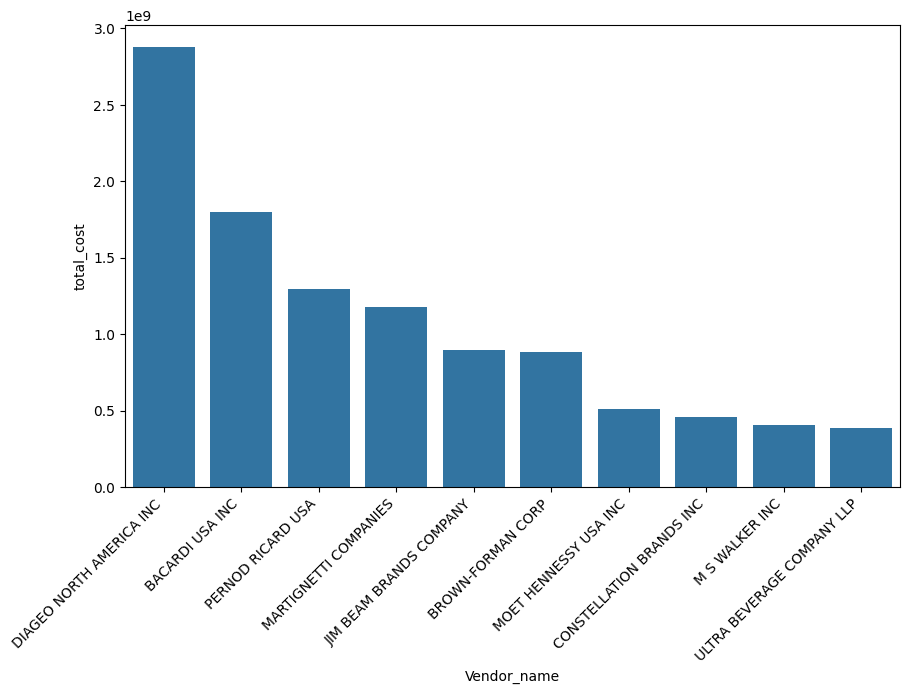

In [147]:
plt.figure(figsize=(10, 6))
sns.barplot(data=cost_by_vendor.head(10), x='Vendor_name', y='total_cost')
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
plt.show()

Ta tiến hành so sánh phần trăm chi phí mua hàng giữa các nhà phân phối trong top 10:

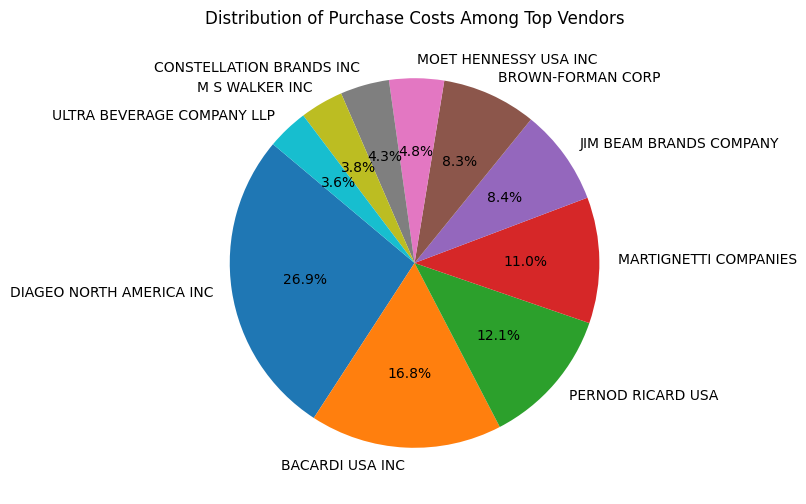

In [148]:
plt.figure(figsize=(10, 6))
plt.pie(cost_by_vendor.head(10)['total_cost'],autopct='%1.1f%%', startangle=140, labels = cost_by_vendor.head(10)['Vendor_name'])
# cost_by_vendor.head(10).plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Purchase Costs Among Top Vendors')
plt.ylabel('')  # to remove the default 'PurchasePrice' label from the y-axis
plt.show()

Từ biểu đồ tròn cho ta thấy top 10 nhà cung cấp dựa theo chi phí mua hàng. Ta có thể thấy rõ ràng DIAGEO NORTH AMERICA INC chiếm ưu thể mạnh khi chiếm hơn 1/4 tổng chi phí của top 10 nhà phân phối.

In [149]:
sales_velocity = sales_fact_table.groupby('Inventory_Id').agg(Total_sales =('Sales_quantity','sum')).reset_index()
sales_velocity.head()
# sales_velocity['Sales_per_day'] = sales_velocity['Total_sales'] / total_days
# sales_velocity.head()

,Inventory_Id,Total_sales
0,10_HORNSEY_1000 ...,1
1,10_HORNSEY_1001 ...,11
2,10_HORNSEY_1005 ...,3
3,10_HORNSEY_10058 ...,6
4,10_HORNSEY_1006 ...,1


In [150]:
sales_velocity.head()

,Inventory_Id,Total_sales
0,10_HORNSEY_1000 ...,1
1,10_HORNSEY_1001 ...,11
2,10_HORNSEY_1005 ...,3
3,10_HORNSEY_10058 ...,6
4,10_HORNSEY_1006 ...,1


In [151]:
sales_velocity = pd.merge(sales_velocity, dim_inventory[['Inventory_Id','Brand']], on='Inventory_Id', how='inner')

In [152]:
sales_velocity.head()

,Inventory_Id,Total_sales,Brand
0,10_HORNSEY_1000 ...,1,1000
1,10_HORNSEY_1001 ...,11,1001
2,10_HORNSEY_1005 ...,3,1005
3,10_HORNSEY_10058 ...,6,10058
4,10_HORNSEY_1006 ...,1,1006


In [153]:
sales_velocity = pd.merge(sales_velocity, dim_product[['Brand', 'Description']], on='Brand', how='inner')
sales_velocity['Description'] = sales_velocity['Description'].str.strip()
sales_velocity = sales_velocity.groupby('Description')['Total_sales'].sum().reset_index()
sales_velocity.head()

,Description,Total_sales
0,(RI) 1,38
1,10 Span Cab Svgn CC,12
2,10 Span Chard CC,72
3,10 Span Pnt Nr CC,31
4,12 Days of Pearls Gift Set,25


In [154]:
total_days = (sales_fact_table['Sales_date'].max() - sales_fact_table['Sales_date'].min()).days
sales_velocity['Sales_per_day'] = sales_velocity['Total_sales'] / total_days

In [155]:
sales_velocity.sort_values(by='Sales_per_day', ascending=False).head(20)

,Description,Total_sales,Sales_per_day
5746,Smirnoff 80 Proof,39742,1324.733333
1116,Capt Morgan Spiced Rum,31942,1064.733333
2240,Dr McGillicuddy's Mentholmnt,22138,737.933333
6762,Yukon Jack,21465,715.500000
3300,Jack Daniels No 7 Black,21004,700.133333
72,Absolut 80 Proof,20282,676.066667
5765,Smirnoff Raspberry Vodka,20114,670.466667
3422,Jim Beam,19162,638.733333
6303,Tito's Handmade Vodka,17825,594.166667
1047,Canadian Club,16768,558.933333


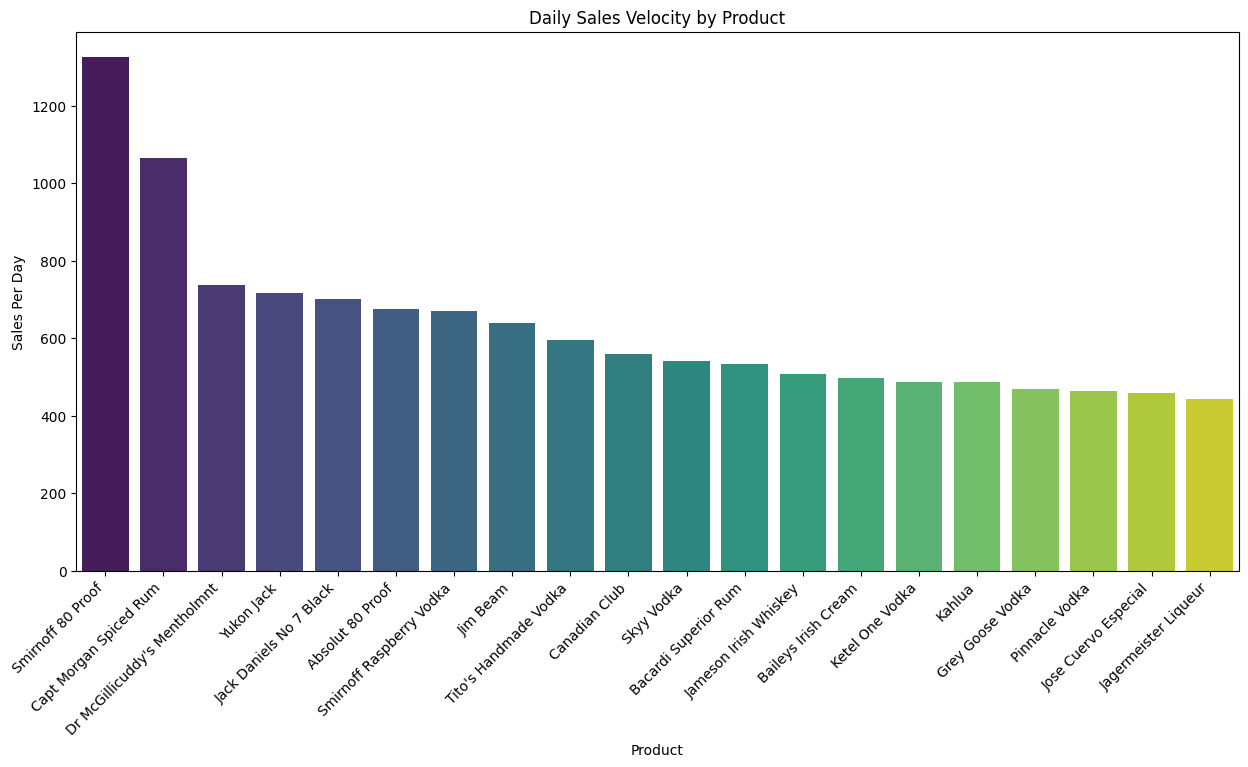

In [156]:
# Sorting the data by Sales_Per_Day in descending order to get top products
top_products = sales_velocity.sort_values(by='Sales_per_day', ascending=False).head(20)  # you can adjust the number as needed

# Creating the bar plot
plt.figure(figsize=(15, 7))
sns.barplot(x='Description', y='Sales_per_day', hue='Description', data=top_products, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Daily Sales Velocity by Product')
plt.xlabel('Product')
plt.ylabel('Sales Per Day')
plt.show()